In [2]:
#import required libraries
import torch
from torch import nn
#we are going to train on the MNIST dataset
from torchvision.datasets import MNIST
#use dataloader to avoid loading too much data at once and crashing the kernel due to insuffiient memory
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
#for plotting out the data
import matplotlib.pyplot as plt
#progress bar
from tqdm import tqdm
import numpy as np
import pandas as pd

In [3]:
#download MNIST
train=MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor())

test=MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor())

In [4]:
#load the datasets
train_load=DataLoader(train,batch_size=100,shuffle=True,num_workers=1)
test_load=DataLoader(test,batch_size=100,shuffle=True,num_workers=1)

torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


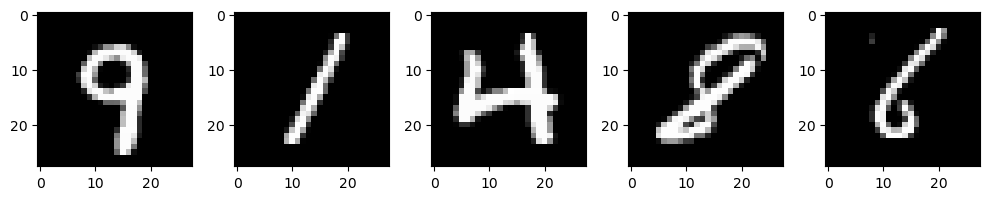

In [5]:
#view the data
plt.figure(figsize=(10,10))
#iterate through the dataset and print out images and its dimensions
for i, (image,label) in enumerate(train_load):
    if i<5:
        print(image[0][0].shape)
        plt.subplot(1,5,i+1)
        plt.imshow(image[0].squeeze(),cmap='gray')
 
    else:
        break
plt.tight_layout()
plt.show()

In [6]:
#100 stands for the number of images
#1 channel- greyscale image
#28x28 image

In [7]:
#write MLP class
class MLP(nn.Module):
    def __init__(self):
        #inherit from nn.Module (base class for all torch modules)
        super().__init__()

        #build the model
        self.layers=nn.Sequential(
            #flatten first dimension-row 1, row 2......... 
            nn.Flatten(),
            #1st layer-input: 28x28=784 dim, output: 500 dim in Dense linear layer
            nn.Linear(28*28,500),
            #apply Relu activation function
            nn.ReLU(),
            #2nd layer-input: 500 dim, output: 300 dim in Dense linear layer
            nn.Linear(500,300),
            #apply Relu activation function
            nn.ReLU(),
            #3rd layer-input: 300 dim, output: 200 dim in Dense linear layer
            nn.Linear(300,200),
            #apply BatchNorm to avoid blowing up the gradient (Layer Norm is for NLP/transformers-the normalization is done across the layer, while Batch Norm is on feature)
            nn.BatchNorm1d(200),
            #apply Relu activation function
            nn.ReLU(),
            #apply Dropout to prevent overfitting (done after activation layer)
            nn.Dropout(0.1),

            #we add in Batch Norm and Dropout in 3rd layer

            #4th layer-input: 200 dim, output: 150 dim in Dense linear layer
            nn.Linear(200,150),
            #apply Relu activation function
            nn.ReLU(),
            #5th layer-input: 150 dim, output: 120 dim in Dense linear layer
            nn.Linear(150,120),
            #apply Relu activation function
            nn.ReLU(),
            #6th layer-input: 120 dim, output: 80 dim in Dense linear layer
            nn.Linear(120,80),
            #apply BatchNorm to avoid blowing up the gradient
            nn.BatchNorm1d(80),
            #apply Relu activation function
            nn.ReLU(),
            #apply Dropout to prevent overfitting
            nn.Dropout(0.1),
            #we add in Batch Norm and Dropout in 6th layer

            #7th layer-input: 80 dim, output: 50 dim in Dense linear layer
            nn.Linear(80,50),
            #apply Relu activation function
            nn.ReLU(),
            #8th layer-input: 50 dim, output: 30 dim in Dense linear layer
            nn.Linear(50,30),
            #apply Relu activation function
            nn.ReLU(),
            #9th layer-input: 30 dim, output: 10 dim in Dense linear layer
            #10 dim because we have 10 classes
            nn.Linear(30,10)
            
        )
    
    def forward(self,x):
        #forward pass-calculate the output
        return self.layers(x)
    
    def fit(self,x,epochs=5):
        #fit the model
        #define loss function
        loss_fn=nn.CrossEntropyLoss()
        #define optimizer
        opt=torch.optim.Adam(self.parameters(),lr=0.01)

        #store current loss
        curr_loss=0
        #training loop
        for i in range(epochs):
            for j, data in enumerate(tqdm(train_load)):
                #get inputs
                inputs,targets=data

                #zero the gradients before backward pass so that we do accumulate gradients from last epoch
                opt.zero_grad()

                #forward pass
                y_pred=self.forward(inputs)

                #calculate loss
                loss=loss_fn(y_pred,targets)

                #perform backward pass
                loss.backward()

                #update weights
                opt.step()  

                #update current loss
                curr_loss+=loss.item()

            print(f"Epoch {i+1}: loss = {curr_loss}")
        print("Training Complete")
    
    def predict(self,x):
        #use model to generate predictions
        y_pred=self.forward(x)
        return y_pred

    def evaluate_model(self,x,verbose=0):
        #evaluate the model
        self.eval()
        #test loop
        run_count_correct=0
        total_count=0
        with torch.no_grad():
            for i, data in enumerate(tqdm(test_load)):
                #get inputs
                inputs,y_true=data

                #generate predictions
                y_pred=torch.argmax(self.predict(inputs),dim=1)
                # print(y_pred)
                # print(y_true)
                #current batch accuracy
                current_count=torch.sum(y_true==y_pred)
                #print out the accuracy for each batch in loaded data if verbose is 1
                if verbose==1:
                    print(f"Batch {i} Accuracy = ",current_count.item()/y_true.shape[0])
                #add to correct count
                run_count_correct+=current_count
                total_count+=y_true.shape[0]
        #calculate overall accuracy across all batches
        overall_accuracy=run_count_correct/total_count
        print(f"Test Accuracy = {overall_accuracy}")
        return overall_accuracy

In [8]:
#fit the model
mlp=MLP()
mlp.fit(train_load,epochs=20)

#evaluate the model on test set
mlp_test_accuracy=mlp.evaluate_model(test_load)
#after training for 10 epochs, the test accuracy is 0.98, indicating that the model performance is extremely good

100%|██████████| 600/600 [00:14<00:00, 41.39it/s]


Epoch 1: loss = 230.71447492018342


100%|██████████| 600/600 [00:14<00:00, 42.54it/s]


Epoch 2: loss = 327.49846977740526


100%|██████████| 600/600 [00:14<00:00, 41.79it/s]


Epoch 3: loss = 401.5778101347387


100%|██████████| 600/600 [00:13<00:00, 43.76it/s]


Epoch 4: loss = 462.7518239431083


100%|██████████| 600/600 [00:13<00:00, 43.04it/s]


Epoch 5: loss = 518.6849524877034


100%|██████████| 600/600 [00:13<00:00, 43.16it/s]


Epoch 6: loss = 565.546609995421


100%|██████████| 600/600 [00:13<00:00, 43.05it/s]


Epoch 7: loss = 606.9512591826497


100%|██████████| 600/600 [00:14<00:00, 42.42it/s]


Epoch 8: loss = 643.9272723080358


100%|██████████| 600/600 [00:13<00:00, 43.04it/s]


Epoch 9: loss = 678.802924661024


100%|██████████| 600/600 [00:13<00:00, 43.31it/s]


Epoch 10: loss = 709.2817554392968


100%|██████████| 600/600 [00:14<00:00, 42.38it/s]


Epoch 11: loss = 739.5804058825888


100%|██████████| 600/600 [00:14<00:00, 42.47it/s]


Epoch 12: loss = 769.1124751819007


100%|██████████| 600/600 [00:14<00:00, 40.21it/s]


Epoch 13: loss = 793.9047426044999


100%|██████████| 600/600 [00:15<00:00, 38.68it/s]


Epoch 14: loss = 818.2968692544091


100%|██████████| 600/600 [00:14<00:00, 41.54it/s]


Epoch 15: loss = 841.1840041727119


100%|██████████| 600/600 [00:14<00:00, 42.61it/s]


Epoch 16: loss = 861.9759351472021


100%|██████████| 600/600 [00:13<00:00, 43.06it/s]


Epoch 17: loss = 882.1352947563864


100%|██████████| 600/600 [00:14<00:00, 42.00it/s]


Epoch 18: loss = 900.36204043834


100%|██████████| 600/600 [00:14<00:00, 42.82it/s]


Epoch 19: loss = 920.5552262832643


100%|██████████| 600/600 [00:13<00:00, 43.06it/s]


Epoch 20: loss = 939.7078334032412
Training Complete


100%|██████████| 600/600 [00:11<00:00, 54.03it/s]

Test Accuracy = 0.9936166405677795


In [9]:
#write CNN class
class CNN(nn.Module):
    def __init__(self):
        #inherit from nn.Module (base class for all torch modules)
        super().__init__()
        
        #build the model
        self.layers=nn.Sequential(
            #no need to flatten the image as we structure the CNN to take in 2d images
            #1st layer- we take in 1 channel and output 5 channels, to capture different features of the image
            #after convolution, we apply max pooling
            #for example, edge detection, contrast of image......
            nn.Conv2d(in_channels=1,out_channels=5,kernel_size=5,padding=2),
            #calc output dim- [28+2*2-1*(5-1)-1]/1 +1 =28
            #apply max pooling
            nn.MaxPool2d(kernel_size=2,stride=2),
            #calc output dim- [28+2*0-1*(2-1)-1]/2 +1 = 14

            #2nd layer - convolution - we take in 5 channels and output 10 channels,kernel still 5, padding 2
            nn.Conv2d(in_channels=5,out_channels=10,kernel_size=5),
            #calc output dim- [14+2*0-1*(5-1)-1]/1 +1 = 10
            #apply max pooling
            nn.MaxPool2d(kernel_size=2,stride=2),
            #calc output dim- [10+2*0-1*(2-1)-1]/2 +1 = 5

            #flatten the output of the previous layer
            nn.Flatten(),

            #3rd layer- linear layer
            #input dim- 7*7 from one channel, we have 10 channels- input dim: 7*7*10, output dim: 200
            nn.Linear(5*5*10,200),
            #this layer is important- without this layer, the gradient will blow up (accuracy is much lower)
            #apply BatchNorm to avoid blowing up the gradient- input dim: 200
            nn.BatchNorm1d(200),
            #apply Relu activation function
            nn.ReLU(),
            #remove dropout since we have many samples, the model is likely to have "seen" all possible datapoints- able to to handle the test set
            #apply Dropout to prevent overfitting (done after activation layer)
            # nn.Dropout(0.1),

            #4th layer- linear layer - input dim: 200, output dim: 50
            nn.Linear(200,50),
            #apply Relu activation function
            nn.ReLU(),

            #5th layer- linear layer - input dim: 50, output dim: 10 (as there are 10 classes)
            nn.Linear(50,10),

        )

    def forward(self,x):
        return self.layers(x)
    
    def fit(self,x,epochs=5):
        #fit the model
        #define loss function
        loss_fn=nn.CrossEntropyLoss()
        #define optimizer
        opt=torch.optim.Adam(self.parameters(),lr=0.01)

        #store current loss
        curr_loss=0
        #training loop
        for i in range(epochs):
            for j, data in enumerate(tqdm(train_load)):
                #get inputs
                inputs,targets=data

                #zero the gradients before backward pass so that we do accumulate gradients from last epoch
                opt.zero_grad()

                #forward pass
                y_pred=self.forward(inputs)

                #calculate loss
                loss=loss_fn(y_pred,targets)

                #perform backward pass
                loss.backward()

                #update weights
                opt.step()  

                #update current loss
                curr_loss+=loss.item()

            print(f"Epoch {i+1}: loss = {curr_loss}")
        print("Training Complete")
    
    def predict(self,x):
        y_pred=self.forward(x)
        return y_pred

    def evaluate_model(self,x,verbose=0):
        #evaluate the model
        self.eval()
        #test loop
        run_count_correct=0
        total_count=0
        with torch.no_grad():
            for i, data in enumerate(tqdm(test_load)):
                #get inputs
                inputs,y_true=data

                #generate predictions
                y_pred=torch.argmax(self.predict(inputs),dim=1)
                # print(y_pred)
                # print(y_true)
                #current batch accuracy
                current_count=torch.sum(y_true==y_pred)
                #print out the accuracy for each batch in loaded data if verbose is 1
                if verbose==1:
                    print(f"Batch {i} Accuracy = ",current_count.item()/y_true.shape[0])
                #add to correct count
                run_count_correct+=current_count
                total_count+=y_true.shape[0]
        #calculate overall accuracy across all batches
        overall_accuracy=run_count_correct/total_count
        print(f"Test Accuracy = {overall_accuracy}")
        return overall_accuracy

In [10]:
cnn=CNN()
cnn.fit(train_load,epochs=15)

#evaluate the model on test set
cnn_test_accuracy=cnn.evaluate_model(test_load)
#after training for 10 epochs, the test accuracy is 0.996, indicating that the model performance is extremely good

100%|██████████| 600/600 [00:12<00:00, 48.57it/s]


Epoch 1: loss = 84.33466117735952


100%|██████████| 600/600 [00:12<00:00, 49.36it/s]


Epoch 2: loss = 120.99040624883492


100%|██████████| 600/600 [00:12<00:00, 49.69it/s]


Epoch 3: loss = 148.81841257901397


100%|██████████| 600/600 [00:12<00:00, 47.85it/s]


Epoch 4: loss = 173.6414594001253


100%|██████████| 600/600 [00:12<00:00, 46.71it/s]


Epoch 5: loss = 193.2544918135536


100%|██████████| 600/600 [00:12<00:00, 47.96it/s]


Epoch 6: loss = 212.26148284324154


100%|██████████| 600/600 [00:12<00:00, 47.82it/s]


Epoch 7: loss = 232.1623952161317


100%|██████████| 600/600 [00:13<00:00, 45.53it/s]


Epoch 8: loss = 248.3615630832428


100%|██████████| 600/600 [00:13<00:00, 46.07it/s]


Epoch 9: loss = 264.4115319979828


100%|██████████| 600/600 [00:12<00:00, 47.94it/s]


Epoch 10: loss = 279.2890466589088


100%|██████████| 600/600 [00:12<00:00, 47.76it/s]


Epoch 11: loss = 292.9352425029647


100%|██████████| 600/600 [00:12<00:00, 48.33it/s]


Epoch 12: loss = 308.16105712741046


100%|██████████| 600/600 [00:12<00:00, 47.72it/s]


Epoch 13: loss = 321.04628788137416


100%|██████████| 600/600 [00:12<00:00, 48.19it/s]


Epoch 14: loss = 335.58414193182034


100%|██████████| 600/600 [00:12<00:00, 48.08it/s]


Epoch 15: loss = 346.2628908612751
Training Complete


100%|██████████| 600/600 [00:12<00:00, 49.31it/s]

Test Accuracy = 0.9965166449546814


In [11]:
#we convert pytorch tensor to a numpy array to read into decision tree
#reshape train data into flat array after converting into np array
train_data=train.data.numpy()
train_data=train_data.reshape(60000,28*28)
#reshape test data into flat array after converting into np array
test_data=test.data.numpy()
test_data=test_data.reshape(60000,28*28)
#convert target into np array
train_target=train.targets.numpy()
test_target=test.targets.numpy()

In [12]:
#other than the neural network, we also use decision tree models
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
#we use grid search to choose best parameters since the number of parameters available for optimization is quite little
#if not Bayes Opt using Optuna or Hyperopt can work too 

#create decision tree object
dec_tree=DecisionTreeClassifier(max_depth=20)

#perform CV to choose best parameters
#min_weight_fraction_leaf probably not needed- since so many samples to train on-even 0.01 is 600 samples in that leaf
#since there are so many samples, we may always have enough samples to perform a split
#probably we can use pruning to improve model generalization ability
#increasing depth increases accuracy, however CV loss does not improve much even after increasing depth- we fix it at 20
#tested increasing pruning parameter to increase generalization power, however we have many samples to train on- the model has "seen" all types of datapoints

# param={"ccp_alpha":np.arange(0,1,0.5,dtype="float")}
# dec_treeCV=GridSearchCV(dec_tree,param)
# dec_treeCV.fit(train_data,train_target)
# #extract best model
# dec_tree_best=dec_treeCV.best_estimator_

#fit decision tree on train data
dec_tree.fit(train_data,train_target)

#generate predictions
dec_tree_y_pred=dec_tree.predict(test_data)
dec_tree_accuracy=np.mean((dec_tree_y_pred==test_target))
print("Test Accuracy = ",dec_tree_accuracy)
#trees can perform well even when compared to neural network models

Test Accuracy =  0.9950166666666667


In [13]:
#try random forest to see if it performs better than decision trees 
from sklearn.ensemble import RandomForestClassifier

#create random forest object and fit random forest
rand_for=RandomForestClassifier(max_depth=20)
rand_for.fit(train_data,train_target)

#generate predictions
rand_for_y_pred=rand_for.predict(test_data)
rand_for_accuracy=np.mean((rand_for_y_pred==test_target))
print("Test Accuracy = ",rand_for_accuracy)

Test Accuracy =  0.9992333333333333


In [25]:
#try xgboost to see if it performs better than decision trees and random forests
from xgboost import XGBClassifier

#create xgboost object and fit xgboost
#deeper tree vs shallower tree - deeper tree use all samples to produce splits, shallower tree uses wrongly classified samples to further train
#we can probably use colsample to random choose columns used in tree growing

#create xgboost object
#set n_estimators=50- grow shallow trees to reduce training time (deep trees are too resource hungry)
#tree depth*number of trees=total depth will be much deeper than just unboosted trees to reach similar accuracy (training on wrong instances )
#subsample- likely to reduce accuracy (use when we suspect that we are overfitting to improve model generalization)
xgboost=XGBClassifier(device="cuda",n_estimators=40)
#sequential calculation- using cuda did not help much
xgboost.fit(train_data,train_target)

#generate predictions
xgboost_y_pred=xgboost.predict(test_data)
xgboost_accuracy=np.mean((xgboost_y_pred==test_target))
print("Test Accuracy = ",xgboost_accuracy)

Test Accuracy =  0.9981666666666666


In [26]:
#now we try xgboost random forest
#create xgboost object and set num_parallel_tree=10, using 10 trees
#the sqrt setting 28/784=0.035 is too low-the tree is less likely the best available split (small datasets- sqrt(20)/20 ~0.25 so still likely to choose the best feature for splitting)
#we can also use subsampling to sample data for each boosting iteration
rf_xgboost=XGBClassifier(device="cuda",n_estimators=40,colsample_bynode=0.25,num_parallel_tree=10)

#fit xgboost random forest
rf_xgboost.fit(train_data,train_target)

#generate predictions
rf_xgboost_y_pred=rf_xgboost.predict(test_data)
rf_xgboost_accuracy=np.mean((rf_xgboost_y_pred==test_target))
print("Test Accuracy = ",rf_xgboost_accuracy)

Test Accuracy =  0.9973666666666666


In [27]:
#table to show the accuracy of different models
#for MLP, the accuracy is a tensor- need to use .item() to extract the value
results=pd.DataFrame({"Model":["MLP","Decision Tree","Random Forest","CNN","XGBoost","XGBoost RF (10 trees)"],
               "Test Accuracy":[mlp_test_accuracy.item(),dec_tree_accuracy,rand_for_accuracy,cnn_test_accuracy.item(),xgboost_accuracy,rf_xgboost_accuracy]})
results["Test Accuracy"]=(results["Test Accuracy"].round(decimals=3)*100).astype(str).add("%")

from tabulate import tabulate
results_list=results.values.tolist()
print(tabulate(results_list,headers=["Model","Test Accuracy"],tablefmt="fancy_grid"))

╒═══════════════════════╤═════════════════╕
│ Model                 │ Test Accuracy   │
╞═══════════════════════╪═════════════════╡
│ MLP                   │ 99.4%           │
├───────────────────────┼─────────────────┤
│ Decision Tree         │ 99.5%           │
├───────────────────────┼─────────────────┤
│ Random Forest         │ 99.9%           │
├───────────────────────┼─────────────────┤
│ CNN                   │ 99.7%           │
├───────────────────────┼─────────────────┤
│ XGBoost               │ 99.8%           │
├───────────────────────┼─────────────────┤
│ XGBoost RF (10 trees) │ 99.7%           │
╘═══════════════════════╧═════════════════╛
